In [18]:
import process as pc
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
%config Completer.use_jedi = False

In [19]:
positive_images_path = pc.DATA_PATH+"/img_align_celeba"
negative_images_path = pc.DATA_PATH+"/caltech-101/101_ObjectCategories"

pc.extract_dataset(positive_images_path)
bad_imgs_path_list = pc.extract_dataset(negative_images_path, folder="multi_folders")

Dataset already extracted


In [20]:
img_list = pc.load_images(positive_images_path, number_of_images=25000, random_seed=7)
images = []
for img in img_list:
    images.append(pc.process_image(pc.DATA_PATH+"/img_align_celeba/"+img))

In [21]:
bad_img_list = []
bad_images = []
for fld in bad_imgs_path_list:
    tmp_img_list = pc.load_images(negative_images_path+"/"+fld, number_of_images=200, random_seed=7)
    bad_img_list += [negative_images_path+"/"+fld+'/'+img for img in tmp_img_list]

for img in bad_img_list:
    bad_images.append(pc.process_image(img))

/home/enrico/Machine_learning/face_detection_project/src/user_warnings.py:4: UserWarning: The requested number of images is greater than the number of images in the folder
  warnings.warn("The requested number of images is greater than the number of images in the folder", UserWarning)


(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

(-0.5, 177.5, 217.5, -0.5)

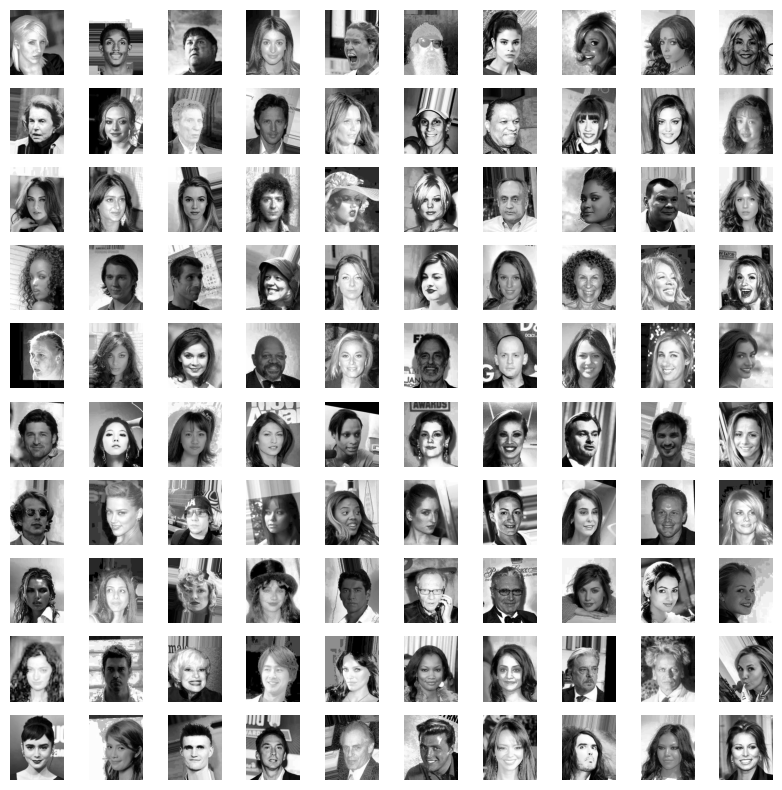

In [22]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j in range(10):
        ax[i, j].imshow(images[i*10+j], cmap='gray')
        ax[i, j].axis('off')

In [23]:
len(images)
len(bad_images)

25000

7170

In [24]:
negative_samples = []
for img in bad_images:
    features = pc.extract_features_image(img)
    if features is not None:
        features_flattened = features.reshape(-1, features.shape[-1])
        negative_samples.extend(features_flattened)
positive_samples = []
for img in images:
    features = pc.extract_features_image(img)
    if features is not None:
        features_flattened = features.reshape(-1, features.shape[-1])
        positive_samples.extend(features_flattened)

negative_samples[:2]
positive_samples[:2]

[array([ 31.,  51.,   9.,   7.,   3.,   4.,   5.,  10.,  39.,  42.,   5.,
         12.,  14.,   9.,   6.,  12.,   5.,   2.,   1.,  56., 129.,  11.,
          2.,   1.,  27.,  34.,   1.,  19.,  47.,   2.,   0.,   0.,  59.,
         27.,  12.,  65.,  25.,   0.,   2.,   5., 135.,  39.,   6.,   8.,
         17.,  48.,  45.,  91.,   7.,   2.,   1.,  27., 135., 135.,  33.,
         15.,  34.,   5.,   0.,  11.,  59.,  32.,   0.,   1.,  92.,   6.,
          1.,  31.,  35.,  11.,   1.,   7., 135.,  94.,  38.,  42.,  15.,
          9.,   6.,  25.,  11.,  15.,  28., 114., 135.,  86.,   9.,   6.,
         26.,   1.,   0.,   1.,  82.,  63.,   1.,   2.,  54.,   0.,   0.,
          8.,  31.,  14.,   1.,  22., 134.,  20.,  12.,   9.,   1.,   0.,
          1.,  39.,  28.,   4.,   8.,  13.,  33.,  76.,  21.,  27.,  10.,
          0.,   0.,   0.,  74., 105.,   4.,   8.], dtype=float32),
 array([ 17.,  37.,  10.,   3.,   9.,   4.,   1.,  19.,  55.,  10.,   6.,
          6.,  24.,  11.,   7.,  56., 148.,  

[array([  0.,   4.,  58.,  88.,   3.,   0.,   0.,   0.,   7.,  11., 113.,
         62.,   0.,   1.,   4.,   8.,   3.,  67.,  61.,   7.,   0.,   6.,
          5.,   3.,  54.,  92.,   6.,   0.,   0.,   0.,   0.,   0.,  19.,
          8.,  15., 113.,  65.,   0.,   0.,   1., 115.,  30.,  20.,  24.,
          7.,  18.,  36.,  93.,  13.,  29.,  11.,  21.,  47., 115.,  44.,
         26.,  58., 115.,   4.,   5.,   9.,   7.,   0.,   0.,  20.,  24.,
          6.,  57., 115.,   3.,   0.,   0., 115., 115.,  86.,  26.,  17.,
          5.,   3.,  18.,  10.,  34., 115., 115.,  49.,  28.,   4.,   6.,
         60.,  76.,  19.,  29.,  10.,   2.,   0.,   0.,   2.,   5.,   1.,
          5., 115.,  71.,   2.,   0.,  40.,  87.,  21.,   2.,  23.,  26.,
          2.,   2.,  27.,  36.,  35.,  16.,   4.,   7.,   2.,   2.,  82.,
         19.,   5.,   4.,   3.,   4.,   0.,   1.], dtype=float32),
 array([  1.,   2.,   1.,   1.,  10.,  56.,  29.,   6.,  21.,   4.,   1.,
          0.,   0.,   4.,  13.,  44.,  59.,  

In [25]:
for i in range(len(negative_samples)):
    if len(negative_samples[i]) != pc.SIFT_FEATURES:
        print(len(negative_samples[i]))
for i in range(len(positive_samples)):
    if len(positive_samples[i]) != pc.SIFT_FEATURES:
        print(i, len(positive_samples[i]))

positive_samples = [sample for sample in positive_samples if len(sample) == pc.SIFT_FEATURES]



In [26]:
negative_labels = np.zeros(len(negative_samples))
positive_labels = np.ones(len(positive_samples))
X = np.vstack((negative_samples, positive_samples))
y = np.concatenate((negative_labels, positive_labels), axis=0)

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [28]:
X_train.shape
y_train.shape

X_train[0]

(3282856, 128)

(3282856,)

array([ 22.,  57., 104.,  42.,   1.,   5.,  14.,   3.,  91.,  74.,   9.,
         0.,   0.,  11.,  21.,  24.,  63.,  95.,   1.,   0.,   0.,  18.,
        20.,  19.,  82.,  76.,   0.,   0.,   0.,   0.,   0.,   8.,  84.,
        51.,  36.,  15.,   2.,  15.,   8.,  14., 139.,  75.,   3.,   0.,
         1.,  22.,  18.,  50.,  79.,  12.,   2.,   2.,  11.,  84.,  34.,
        42., 113.,  28.,   3.,   6.,   0.,   2.,   1.,  23.,  53.,   1.,
         0.,   0.,   1.,  35., 139.,  41., 139., 123.,  19.,   1.,   1.,
         6.,  40.,  54.,  40., 101.,  65.,  14.,  18.,  31.,   5.,  12.,
        52.,  37.,  39.,  29.,   1.,   3.,   1.,  11.,   1.,   6.,  13.,
         1.,   1.,  50., 139.,   5.,  18.,  22.,   4.,   0.,   1.,  40.,
       104.,  22.,   9.,  54.,  26.,   0.,   0.,   7.,  25.,  11.,   9.,
        27.,  52.,   6.,   0.,   0.,   8.,  34.], dtype=float32)

PCA(n_components=128, random_state=7, whiten=True)

(0.0, 1.02)

Text(0.5, 0, 'Number of components')

Text(0, 0.5, 'Explained variance')

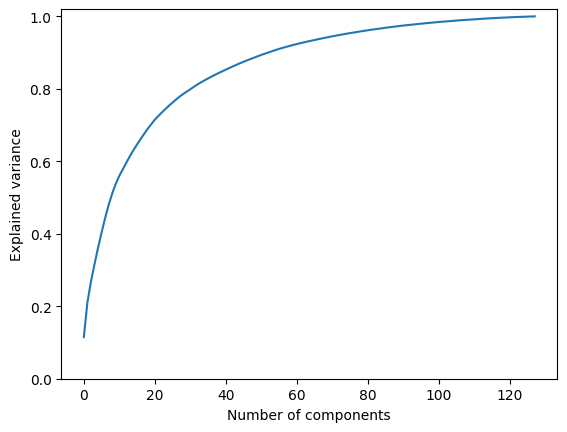

array([0.11475063, 0.20997989, 0.26768497, 0.31554881, 0.36109168,
       0.40305104, 0.44338015, 0.48004954, 0.51137354, 0.53793159,
       0.55997172, 0.57847275, 0.59660333, 0.61469464, 0.63108978,
       0.64671078, 0.66171697, 0.67598472, 0.68982395, 0.70255219,
       0.71494102, 0.7250161 , 0.73504665, 0.74445096, 0.75366348,
       0.76234232, 0.77066733, 0.77862977, 0.78583795, 0.79248309,
       0.79909849, 0.80563325, 0.81206454, 0.81783286, 0.8234675 ,
       0.8288236 , 0.83399789, 0.83896857, 0.84386911, 0.84850491,
       0.85312519, 0.85766512, 0.86208557, 0.86650522, 0.87071687,
       0.87478924, 0.8787535 , 0.88254828, 0.88628186, 0.89000688,
       0.89369001, 0.89711567, 0.90053378, 0.90380777, 0.90707578,
       0.91017413, 0.91320872, 0.9159173 , 0.91859617, 0.92126775,
       0.92371415, 0.92606634, 0.92837402, 0.93058074, 0.93276832,
       0.93491392, 0.93700473, 0.93906309, 0.94108666, 0.94306797,
       0.94501934, 0.94685689, 0.94867275, 0.95042845, 0.95214

In [29]:
from sklearn.decomposition import PCA

pca = PCA(n_components=128, whiten=True, random_state=7)
pca.fit(X_train)
var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(var)
plt.ylim(0, 1.02)
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.show()
var


In [30]:
idx = [i for i in range(len(var)) if var[i] > 0.95]
idx

[73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127]

In [36]:
pca = PCA(n_components=75, whiten=True, random_state=7)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

PCA(n_components=75, random_state=7, whiten=True)

In [37]:
X_train_pca.shape
y_train.shape

(3282856, 75)

(3282856,)

In [38]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

svm_clf = make_pipeline(MinMaxScaler(), SVC(kernel='linear', max_iter=7500))
svm_clf.fit(X_train_pca, y_train)

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = svm_clf.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.578093491650573


In [35]:
pipeline_save_path = pc.DATA_PATH+"/svm_pipeline_2.pkl"

import joblib
joblib.dump(svm_clf, pipeline_save_path)

['../data/svm_pipeline.pkl']